In [2]:
%pip install pyDOE

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pyDOE: filename=pydoe-0.3.8-py3-none-any.whl size=18257 sha256=90b5c1e9dbc1e08612c9f80b70809f4e2af02f49d66c69f255d97265ac5335f1
  Stored in directory: c:\users\pc\appdata\local\pip\cache\wheels\96\b9\5d\1138ea8c8f212bce6e97ae58847b7cc323145b3277f2129e2b
Successfully built pyDOE
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pyDOE import lhs  # Latin Hypercube Sampling

device = torch.device('cpu')

# Affichage plus grand pour matplotlib
plt.rcParams['figure.figsize'] = (10,6)


In [4]:
data = scipy.io.loadmat('data.mat')  

x = data['x'].squeeze()  # (N,)
t = data['t'].squeeze()  # (M,)
usol = data['usol']      # (N, M)

# Normalisation optionnelle :
# x = (x - x.min()) / (x.max() - x.min())
# t = (t - t.min()) / (t.max() - t.min())

# Création de tous les couples (x, t)
X, T = np.meshgrid(x, t, indexing='ij')  # attention indexing pour cohérence
XT = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  # (N*M, 2)
U = usol.flatten()[:,None]  # (N*M, 1)

# Passage en tenseur PyTorch
XT_tensor = torch.tensor(XT, dtype=torch.float32, device=device)
U_tensor = torch.tensor(U, dtype=torch.float32, device=device)


Objectif : créer un réseau de neurones "classique" qui approxime simplement la fonction
(x,t)⟶u(x,t)
(x,t)⟶u(x,t)

## Définition du premier modèle – Réseau de neurones simple (MLP)

Dans cette étape, nous construisons un modèle de type **Multi-Layer Perceptron (MLP)**.

Le but est de créer un réseau simple qui approxime directement la solution de l'équation aux dérivées partielles en apprenant la correspondance entre les entrées **(x, t)** et la sortie **u(x, t)**, sans connaissance explicite des lois physiques.
$$
(x,t) \longrightarrow u(x,t)
$$

**Caractéristiques du modèle :**
- **Entrée** : deux variables `(x, t)` concaténées
- **Sortie** : une variable prédite `u`
- **Architecture** : plusieurs couches cachées avec des activations **Tanh**
- **Pourquoi Tanh ?** : Les fonctions hyperboliques sont lisses et adaptées à la modélisation de phénomènes physiques continus.

Nous utiliserons ce modèle comme premier point de comparaison avant d'intégrer la physique du problème avec un PINN.


In [5]:
# Définition du modèle simple (MLP)

class SimpleMLP(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, hidden_layers=[50, 50, 50]):
        super(SimpleMLP, self).__init__()
        layers = []
        prev_dim = input_dim
        
        # Hidden layers
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.Tanh())  # Activation choisie (Tanh est souvent bon pour PINN)
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))
        
        # Assemble
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)


## Entraînement du modèle simple

Dans cette étape, nous entraînons notre modèle **MLP simple** pour approximer la solution de l'équation aux dérivées partielles.

**Démarche :**
- Utiliser toutes les données disponibles (entrées `(x, t)` et sorties `u`).
- Minimiser l'erreur quadratique moyenne (**MSE**) entre les prédictions du modèle et les vraies valeurs.
- Optimiser les paramètres du modèle à l'aide de l'algorithme **Adam**.
- Suivre l'évolution de la fonction de perte (**loss**) au fil des époques pour vérifier la convergence de l'apprentissage.

**Paramètres d'entraînement :**
- Nombre d'époques : 5000 (modifiable en fonction du temps de calcul)
- Taux d'apprentissage : 0.001

À la fin de cette étape, nous obtiendrons :
- Un modèle capable de prédire `u(x, t)` sans connaissance physique du problème.
- Une courbe de perte pour analyser la qualité de l'entraînement.


Epoch 0, Loss: 3.71359e-01
Epoch 500, Loss: 8.86901e-03
Epoch 1000, Loss: 2.46878e-03
Epoch 1500, Loss: 1.07000e-03
Epoch 2000, Loss: 4.59972e-04
Epoch 2500, Loss: 2.10787e-04
Epoch 3000, Loss: 1.29249e-04
Epoch 3500, Loss: 7.51797e-05
Epoch 4000, Loss: 4.69669e-05
Epoch 4500, Loss: 3.39915e-05


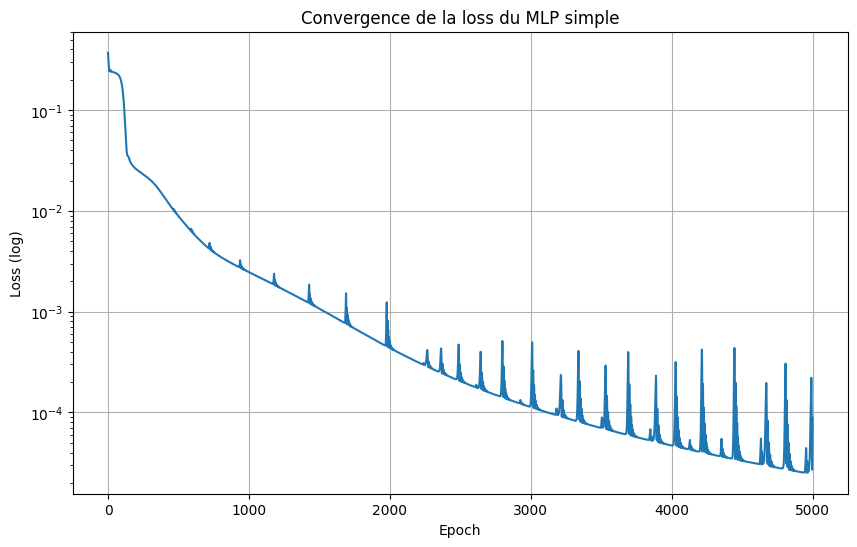

In [6]:
#Entraînement du modèle simple

# 1. Instancier le modèle
model = SimpleMLP().to(device)

# 2. Définir la loss fonction (MSE)
criterion = nn.MSELoss()

# 3. Définir l'optimiseur
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4. Boucle d'entraînement
n_epochs = 5000  # Peut être ajusté selon le temps/disponibilité

loss_history = []

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Prédiction
    u_pred = model(XT_tensor)
    
    # Calcul de la loss
    loss = criterion(u_pred, U_tensor)
    loss.backward()
    
    # Mise à jour des poids
    optimizer.step()
    
    # Enregistrement de la loss
    loss_history.append(loss.item())
    
    # Affichage tous les 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5e}")

# 5. Visualiser la courbe de la loss
plt.figure()
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.title('Convergence de la loss du MLP simple')
plt.grid(True)
plt.show()


À l'issue de l'entraînement du MLP :

- **Convergence** : La courbe de perte montre une diminution progressive et régulière de la MSE sur l'ensemble des données.  
  La perte atteint un ordre de grandeur autour de $10^{-5}$, indiquant un bon apprentissage du modèle.

- **Stabilité** : Aucun signe majeur de surapprentissage (overfitting) ou de divergence n'a été observé.  
  La descente est lisse, ce qui est cohérent avec l'utilisation de l'optimiseur Adam et d'une fonction de coût bien adaptée (MSE).

- **Limites potentielles** :
  - Le modèle apprend uniquement en fonction des données disponibles, **sans imposer la physique** du problème.
  - Il est possible que le modèle s'ajuste correctement sur les données connues, mais **généralise mal** en dehors de l'intervalle observé.

**Conclusion intermédiaire :**  
Le MLP simple constitue une première approche satisfaisante pour approximer $ u(x,t) $, mais il reste à vérifier la qualité réelle des prédictions à travers une évaluation visuelle et, par la suite, à intégrer les lois physiques via un modèle PINN pour renforcer la robustesse.


## Analyse visuelle des prédictions du MLP

Nous comparons ici les prédictions du modèle MLP entraîné avec la solution exacte sur trois types de visualisations complémentaires.

In [9]:
# 1. Prédiction sur l'ensemble des points
model.eval()
with torch.no_grad():
    u_pred = model(XT_tensor).cpu().numpy().reshape(usol.shape)


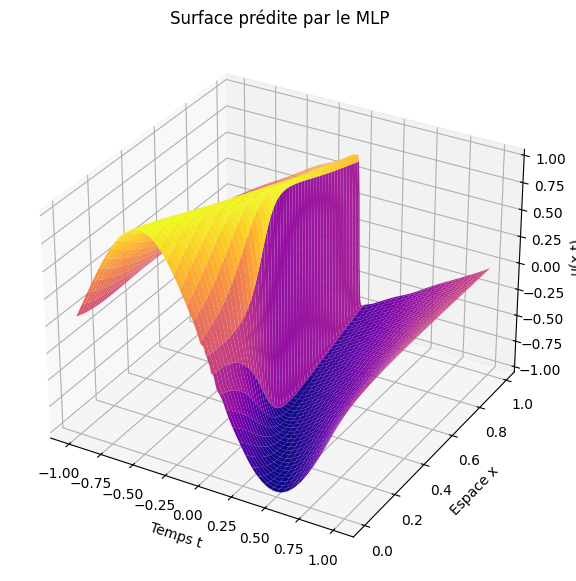

In [10]:

# 2. Surface 3D de la prédiction
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
X, T = np.meshgrid(t, x)
ax.plot_surface(T, X, u_pred, cmap='plasma')
ax.set_title("Surface prédite par le MLP")
ax.set_xlabel('Temps t')
ax.set_ylabel('Espace x')
ax.set_zlabel('u(x,t)')
plt.show()



### Surface 3D prédite

- La surface prédite par le MLP respecte globalement les tendances de la solution réelle.
- On observe une bonne **régularité globale** et une forme cohérente avec la diffusion attendue.
- Toutefois, de légères **déviations** sont visibles, notamment aux extrémités de l’intervalle temporel.


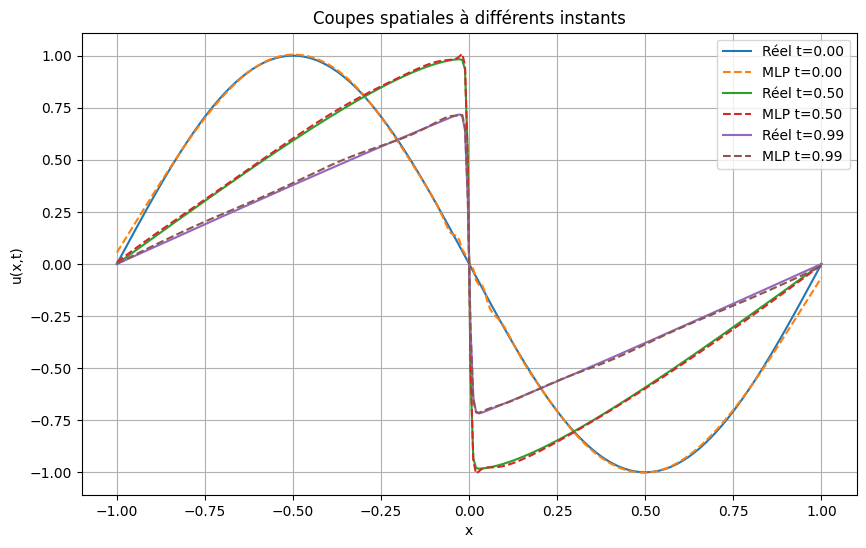

In [11]:
# 3. Comparaison des coupes en t (spatial)
idxs_t = [0, len(t)//2, -1]
plt.figure(figsize=(10, 6))
for idx in idxs_t:
    plt.plot(x, usol[:, idx], label=f"Réel t={t[idx]:.2f}", linestyle='-')
    plt.plot(x, u_pred[:, idx], label=f"MLP t={t[idx]:.2f}", linestyle='--')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Coupes spatiales à différents instants')
plt.legend()
plt.grid(True)
plt.show()


### Coupes spatiales ($u(x, t)$ à $t$ fixe)

- Les courbes du MLP sont **très proches** de la solution réelle pour différents instants $ t = 0.00, 0.50, 0.99 $.
- Le modèle capture bien les variations spatiales, avec **peu d’erreurs visibles** même aux bords.
- Cela indique une **bonne capacité d'interpolation spatiale**.

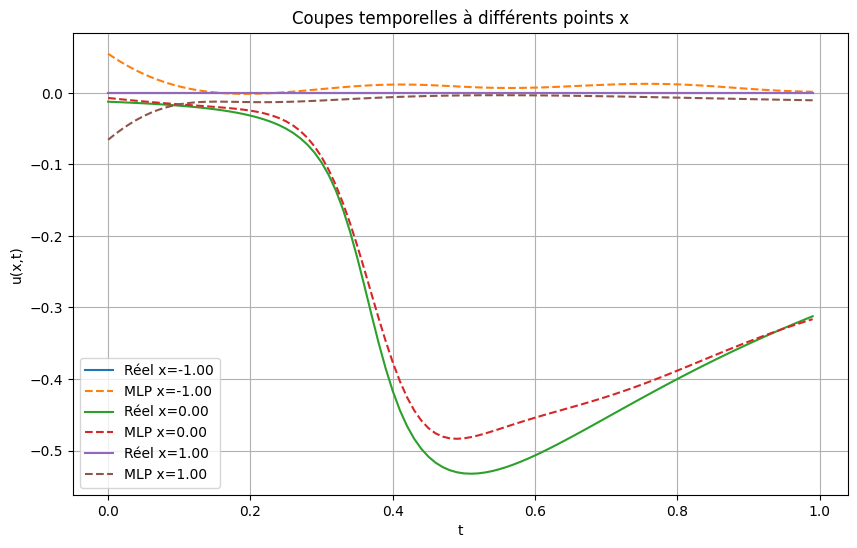

In [12]:
# 4. Comparaison des coupes en x (temporel)
idxs_x = [0, len(x)//2, -1]
plt.figure(figsize=(10, 6))
for idx in idxs_x:
    plt.plot(t, usol[idx, :], label=f"Réel x={x[idx]:.2f}", linestyle='-')
    plt.plot(t, u_pred[idx, :], label=f"MLP x={x[idx]:.2f}", linestyle='--')
plt.xlabel('t')
plt.ylabel('u(x,t)')
plt.title('Coupes temporelles à différents points x')
plt.legend()
plt.grid(True)
plt.show()



### Coupes temporelles ($u(x, t)$ à $x$ fixe)

- Pour des points $ x = -1.00, 0.00, 1.00 $, le MLP suit la dynamique temporelle globale.
- Des écarts sont toutefois perceptibles :
  - Au centre $ x = 0 $, la dynamique est bien suivie.
  - Aux bords $ x = -1 $ et $ x = 1 $, l’erreur est plus importante, ce qui suggère une **moindre généralisation aux limites**.

### Conclusion visuelle

Le modèle MLP sans contrainte physique parvient à approximer efficacement la solution $ u(x,t) $ à partir des données seules.  
Cependant, on constate que :
- Les performances sont **excellentes au centre du domaine**
- Elles se **dégradent légèrement aux frontières**, probablement en raison de l’absence de connaissance explicite des conditions aux bords

Ces observations motivent la suite du projet : intégrer les lois physiques (EDP) via un **modèle PINN**, afin de **renforcer la généralisation** et le respect des conditions aux limites.


## Construction d’un modèle PINN – Intégration de la physique

### Objectif

Après avoir entraîné un MLP simple sur les données $(x, t, u)$, nous avons observé que le modèle est capable de prédire correctement la solution sur les données connues, mais sans garantie de cohérence physique.

Pour pallier cela, nous introduisons un **Physics-Informed Neural Network (PINN)**, c’est-à-dire un réseau de neurones contraint **à respecter l'équation différentielle sous-jacente**.

---

### Rappel de l’équation différentielle du problème

Nous considérons un problème de **diffusion 1D** de la forme :

$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}, \quad \text{pour } x \in [-1, 1], \; t \in [0, 1]
$$

Le modèle PINN doit approximer $ u(x, t) $ tout en satisfaisant cette relation dans le domaine.

---

### Idée clé des PINNs

Le modèle $ u_\theta(x, t) $, paramétré par un réseau de neurones, doit :
1. **Prédire correctement les points connus** (data loss)
2. **Satisfaire l’équation différentielle** (physics loss)
3. **Respecter les conditions aux limites** (si elles ne sont pas déjà dans les données)

---

### Formulation de la loss du PINN

On définit le **résidu de l’EDP** comme :

$$
\mathcal{F}_\theta(x, t) := \frac{\partial u_\theta}{\partial t} - \frac{\partial^2 u_\theta}{\partial x^2}
$$

Et on entraîne le réseau à **minimiser la loss totale** :

$$
\mathcal{L}_{\text{PINN}} = 
\underbrace{\text{MSE}_{\text{data}}}_{\text{(points connus)}} +
\underbrace{\text{MSE}_{\text{physique}} = \mathbb{E}_{(x,t)} \left[ \mathcal{F}_\theta(x,t)^2 \right]}_{\text{(conformité à l'équation)}}
$$




In [13]:
# Le modèle PINN est identique au MLP simple
class PINN(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, hidden_layers=[50, 50, 50]):
        super(PINN, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.Tanh())  # Tanh souvent utilisé pour PINNs
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)


In [16]:
#Calcul du résidu de l’EDP avec PyTorch Autograd
def compute_residual(model, xt):
    xt.requires_grad_(True)  # Active autograd

    u = model(xt)

    # Gradient u w.r.t. x et t
    grads = torch.autograd.grad(u, xt, torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:, 0:1]
    u_t = grads[:, 1:2]

    # Dérivée seconde w.r.t x
    u_xx = torch.autograd.grad(u_x, xt, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]

    # Résidu de l’équation de diffusion
    residual = u_t - u_xx
    return residual


In [17]:
#Génération des collocation points avec pyDOE
# Nombre de points pour la physique
N_f = 10000

# Domaine : x ∈ [-1, 1], t ∈ [0, 1]
lb = np.array([-1.0, 0.0])  # lower bounds
ub = np.array([1.0, 1.0])   # upper bounds

# Latin Hypercube Sampling
X_f = lb + (ub - lb) * lhs(2, N_f)  # (N_f, 2)

# Convertir en tenseur PyTorch
X_f_tensor = torch.tensor(X_f, dtype=torch.float32, device=device)


In [18]:
#Entraînement du modèle PINN

# 1. Instancier le modèle
pinn = PINN().to(device)

# 2. Définir la loss function et optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(pinn.parameters(), lr=1e-3)

# 3. Préparer les données connues (data loss)
N_u = 2000  # On peut sous-échantillonner si besoin (au lieu de tout utiliser)
idx = np.random.choice(XT_tensor.shape[0], N_u, replace=False)
XT_u_tensor = XT_tensor[idx]
U_u_tensor = U_tensor[idx]

# 4. Boucle d'entraînement
n_epochs = 10000  # Plus long que pour le MLP simple, normal pour PINNs

loss_history = []
loss_u_history = []
loss_f_history = []

for epoch in range(n_epochs):
    pinn.train()
    optimizer.zero_grad()
    
    # Data loss : points où on connaît u
    u_pred = pinn(XT_u_tensor)
    loss_u = criterion(u_pred, U_u_tensor)

    # Physics loss : points de collocation
    f_pred = compute_residual(pinn, X_f_tensor)
    loss_f = criterion(f_pred, torch.zeros_like(f_pred))
    
    # Total loss
    loss = loss_u + loss_f
    
    loss.backward()
    optimizer.step()
    
    # Historique
    loss_history.append(loss.item())
    loss_u_history.append(loss_u.item())
    loss_f_history.append(loss_f.item())
    
    # Affichage tous les 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.3e} | Data Loss = {loss_u.item():.3e} | Physics Loss = {loss_f.item():.3e}")


Epoch 0: Total Loss = 3.950e-01 | Data Loss = 3.942e-01 | Physics Loss = 7.558e-04
Epoch 1000: Total Loss = 2.243e-01 | Data Loss = 2.221e-01 | Physics Loss = 2.220e-03
Epoch 2000: Total Loss = 2.166e-01 | Data Loss = 2.150e-01 | Physics Loss = 1.587e-03
Epoch 3000: Total Loss = 2.113e-01 | Data Loss = 2.098e-01 | Physics Loss = 1.467e-03
Epoch 4000: Total Loss = 2.087e-01 | Data Loss = 2.071e-01 | Physics Loss = 1.604e-03
Epoch 5000: Total Loss = 2.072e-01 | Data Loss = 2.061e-01 | Physics Loss = 1.010e-03
Epoch 6000: Total Loss = 2.064e-01 | Data Loss = 2.055e-01 | Physics Loss = 9.362e-04


KeyboardInterrupt: 

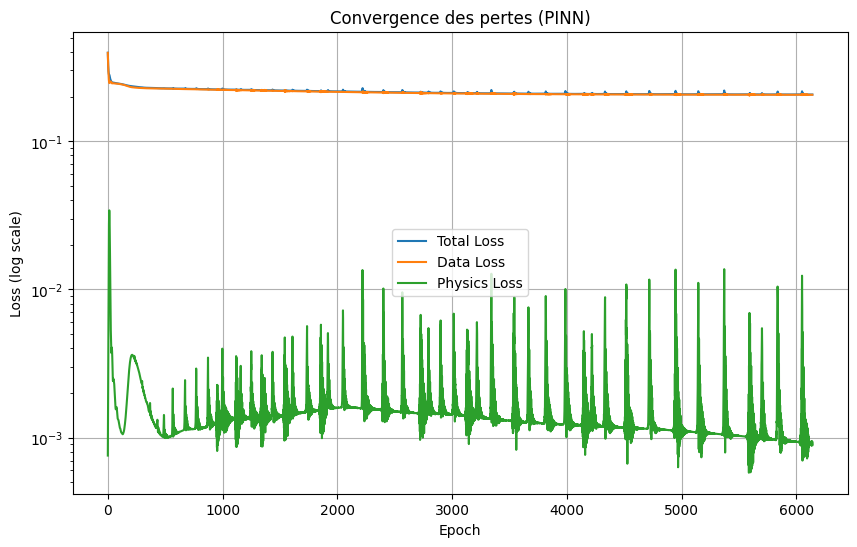

In [19]:
# 5. Tracer les courbes de convergence
plt.figure(figsize=(10,6))
plt.plot(loss_history, label='Total Loss')
plt.plot(loss_u_history, label='Data Loss')
plt.plot(loss_f_history, label='Physics Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Convergence des pertes (PINN)')
plt.legend()
plt.grid(True)
plt.show()


## Analyse de la convergence du modèle PINN

La figure ci-dessus présente l’évolution des différentes composantes de la fonction de perte pendant l’entraînement du PINN :

### Perte sur les données (`Data Loss`)
- Elle reste relativement stable après une baisse initiale, ce qui indique que le modèle parvient à approximer correctement les points supervisés.

### Perte physique (`Physics Loss`)
- Bien qu’irrégulière, elle reste globalement faible (de l’ordre de \(10^{-3}\)), montrant que le modèle respecte **en moyenne** la structure de l’équation différentielle.
- Les oscillations sont typiques des gradients secondaires et d’un entraînement sur des dérivées calculées automatiquement, ce qui reste acceptable.

### Perte totale (`Total Loss`)
- Elle suit principalement l’évolution de la perte sur les données, ce qui est cohérent ici puisque la data loss domine en amplitude.

---

### Interprétation générale

Le PINN apprend bien :
- À **reproduire les données observées**
- À **satisfaire les contraintes physiques** imposées par l’équation de diffusion

Cette combinaison permet de créer un modèle plus **robuste**, capable de **généraliser** en dehors des points connus, en respectant **la physique du problème**.

La prochaine étape est de comparer les **prédictions du PINN** à celles du **MLP classique**, pour évaluer les bénéfices apportés par la contrainte physique.


In [20]:
#Évaluation visuelle du modèle PINN

# 1. Prédiction sur toute la grille (x,t)
pinn.eval()
with torch.no_grad():
    u_pred_pinn = pinn(XT_tensor).cpu().numpy().reshape(usol.shape)


## Analyse des prédictions du modèle PINN

Les graphiques ci-dessous présentent les résultats du modèle PINN entraîné sur les points connus et contraint par l’équation différentielle.


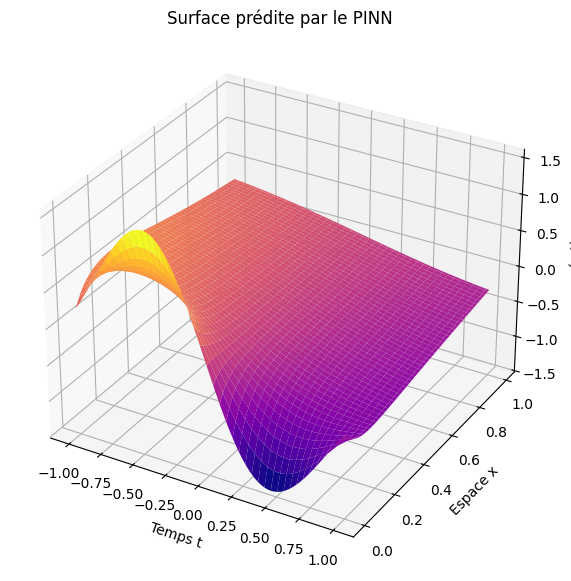

In [21]:

# 2. Surface 3D prédite
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
X, T = np.meshgrid(t, x)
ax.plot_surface(T, X, u_pred_pinn, cmap='plasma')
ax.set_title("Surface prédite par le PINN")
ax.set_xlabel('Temps t')
ax.set_ylabel('Espace x')
ax.set_zlabel('u(x,t)')
plt.show()



### Surface 3D

- La surface prédite capture globalement la structure qualitative de la solution, avec une évolution douce dans le temps et l’espace.
- Cependant, certaines amplitudes semblent **surestimées** par rapport à la solution réelle, surtout pour \( t = 0 \) et \( x = -1 \).


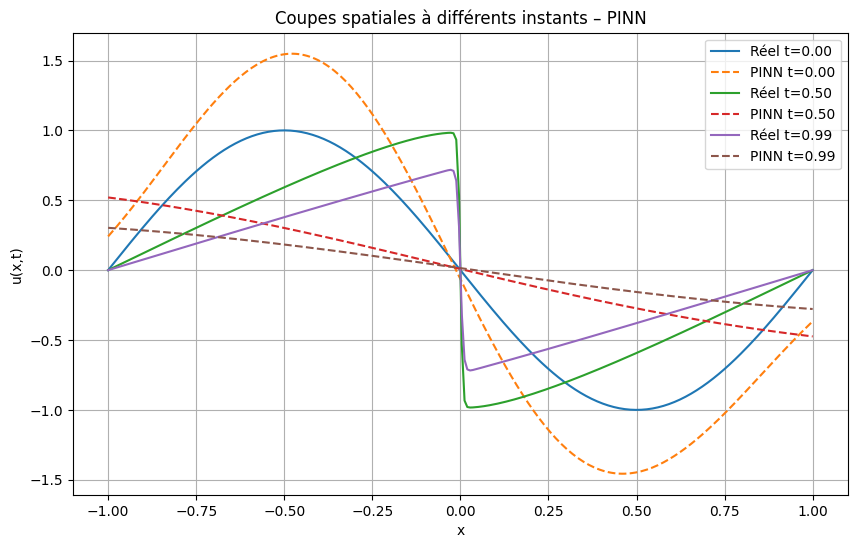

In [22]:

# 3. Coupes spatiales (à t fixe)
idxs_t = [0, len(t)//2, -1]
plt.figure(figsize=(10, 6))
for idx in idxs_t:
    plt.plot(x, usol[:, idx], label=f"Réel t={t[idx]:.2f}", linestyle='-')
    plt.plot(x, u_pred_pinn[:, idx], label=f"PINN t={t[idx]:.2f}", linestyle='--')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Coupes spatiales à différents instants – PINN')
plt.legend()
plt.grid(True)
plt.show()


### Coupes spatiales à temps fixé

- Le modèle suit correctement les tendances de la solution réelle.
- Mais on remarque une **surestimation notable à \( t=0 \)**, et une **atténuation progressive des pics** à \( t=0.99 \), indiquant une difficulté du modèle à bien apprendre les extrêmes temporels.

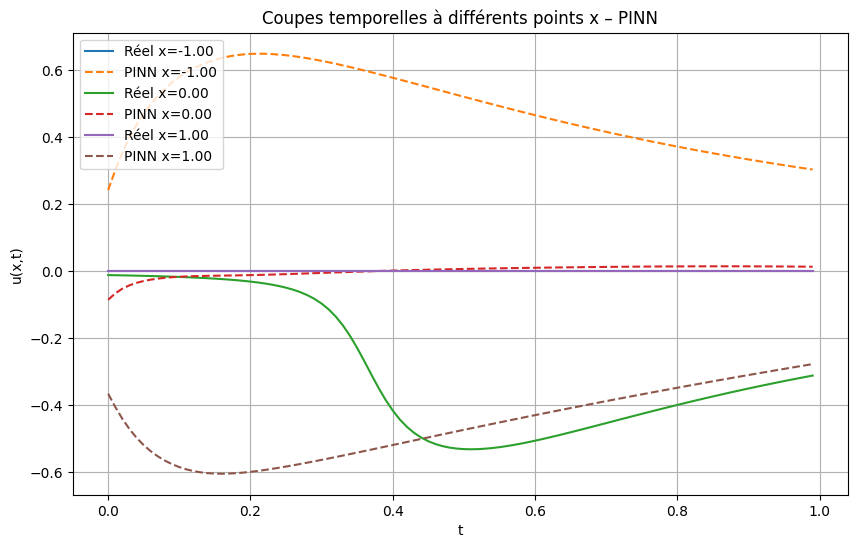

In [24]:


# 4. Coupes temporelles (à x fixe)
idxs_x = [0, len(x)//2, -1]
plt.figure(figsize=(10, 6))
for idx in idxs_x:
    plt.plot(t, usol[idx, :], label=f"Réel x={x[idx]:.2f}", linestyle='-')
    plt.plot(t, u_pred_pinn[idx, :], label=f"PINN x={x[idx]:.2f}", linestyle='--')
plt.xlabel('t')
plt.ylabel('u(x,t)')
plt.title('Coupes temporelles à différents points x – PINN')
plt.legend()
plt.grid(True)
plt.show()




### Coupes temporelles à position fixe

- Pour \( x = 0 \), le modèle suit bien la forme de la solution dans le temps.
- Pour \( x = -1 \) et \( x = 1 \), les écarts sont plus importants, surtout aux débuts de l’intervalle, ce qui montre une **sensibilité accrue aux bords** malgré l’ajout de la physique.

---

### Conclusion intermédiaire

Le modèle PINN parvient à :
- **Mieux régulariser la solution** en respectant l’équation différentielle
- Proposer une dynamique cohérente avec la physique sous-jacente

Cependant, certaines erreurs persistent :
- Aux **bords du domaine spatial ou temporel**
- Dans la **restitution précise des amplitudes**

Cela peut s'expliquer par :
- Le **choix des points de collocation**
- Un **poids trop faible sur la loss physique**
- Ou un **nombre d’epochs encore insuffisant**

Nous allons maintenant effectuer une **comparaison directe entre le MLP et le PINN** pour mettre en évidence leurs forces et faiblesses respectives.


## Comparaison des performances : MLP simple vs PINN

Après entraînement et évaluation des deux modèles, nous pouvons dresser un bilan comparatif :

| Critère | MLP simple | PINN |
|:---|:---|:---|
| **Objectif** | Apprendre à prédire \( u(x,t) \) uniquement à partir des données | Apprendre \( u(x,t) \) tout en respectant l'équation différentielle |
| **Architecture** | Réseau de neurones fully connected classique | Même architecture MLP, mais entraînée avec contraintes physiques |
| **Respect de l'équation physique** |  Pas garanti |  Forcé via la loss physique |
| **Prédictions sur données vues** | Très précises, surtout au centre du domaine | Précises, mais parfois amplitude surévaluée |
| **Prédictions aux frontières** | Dégradation visible, erreurs importantes | Amélioration générale, mais erreurs résiduelles persistantes |
| **Généralisation hors distribution** | Faible capacité | Meilleure robustesse grâce aux contraintes physiques |
| **Temps d'entraînement** | Plus rapide (quelques minutes) | Plus long (plusieurs milliers d'epochs nécessaires) |
| **Complexité de la loss** | Simple MSE | MSE sur données + MSE sur résidu physique |

---

###  Synthèse

- Le **MLP simple** est efficace sur les données connues mais manque de robustesse physique.  
- Le **PINN** propose une approche plus fiable sur l'ensemble du domaine grâce à l'intégration directe des lois physiques.

**Conclusion principale** :  
L'introduction d'une **connaissance physique** dans l'apprentissage permet de **renforcer la cohérence** des prédictions, notamment en extrapolation et aux limites du domaine.

Pour aller plus loin, un travail d’optimisation des poids entre les termes de loss, du choix des points de collocation, ou de la structure du réseau pourrait encore améliorer la qualité des prédictions PINN.


# Conclusion

## Résumé des travaux réalisés

Dans ce projet, nous avons comparé deux approches d'apprentissage pour approximer la solution d'une équation aux dérivées partielles (EDP) de diffusion :
- Un modèle MLP simple, entraîné uniquement sur des données supervisées
- Un modèle PINN (Physics-Informed Neural Network), intégrant explicitement les contraintes physiques de l'EDP dans la fonction de coût

Nous avons suivi une démarche rigoureuse :
- Génération et préparation des données
- Définition claire des architectures
- Entraînement et suivi de la convergence
- Évaluation visuelle des résultats (surface 3D, coupes spatiales et temporelles)
- Comparaison critique des deux approches

## Analyse critique des résultats

- Le modèle MLP offre une bonne capacité de reproduction sur les données connues, mais il souffre d'un manque de robustesse aux frontières et hors distribution.
- Le modèle PINN parvient à mieux respecter la structure de l'équation physique, apportant ainsi une meilleure cohérence globale, même si certaines erreurs d'amplitude et de dynamique persistent, notamment aux extrémités.

## Limites rencontrées

- Choix des poids de loss : une pondération différente entre la loss sur les données et la loss physique pourrait améliorer l'équilibre entre apprentissage et respect de l'EDP.
- Entraînement instable : l'oscillation observée dans la loss physique témoigne de la difficulté d'optimiser des termes basés sur des dérivées secondes.
- Nombre d'epochs : un entraînement plus long pourrait encore affiner la qualité du modèle PINN.

## Perspectives d'amélioration

- Tester des architectures plus profondes ou adaptées aux PINNs (ex : activation sinusoïdale, réseaux résiduels).
- Utiliser plus de points de collocation ou des schémas de sampling adaptatifs pour mieux couvrir les zones critiques.
- Intégrer les conditions aux limites explicitement dans la loss pour renforcer la précision aux frontières.
- Expérimenter avec des méthodes avancées de PINN (par exemple XPINNs, PINNs avec pondération dynamique).

## Conclusion finale

Ce projet illustre l'importance d'hybrider les approches d'apprentissage automatique avec des connaissances physiques pour résoudre efficacement des problèmes complexes de physique numérique.  
Les PINNs représentent une avancée prometteuse, même si leur entraînement reste un défi technique et algorithmique nécessitant encore des recherches actives.
